# NNDataset for training neural networks
A `NNDataset` is a collection of `MPPData`s (one for train/val/test). It is created using a parameter file defining its properties.

This notebooks shows:
- how to create a dataset from parameters
- how to iterate over an existing dataset



TODO for actual examples, need to handle downloading of files
TODO add more info text 
TODO change dataset?

+ example creation from params dict here!
+ after creation load NNDataset + show how to iterate over samples for training

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

import os

from campa.data import NNDataset, create_dataset
from campa.utils import load_config
from campa.constants import SCRIPTS_DIR

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


## Create NNDataset
`NNDataset` is created with a config file that specifies from which folders to take the data and how to preprocess the data.

Here, we will use [params/example_data_params.py](params/example_data_params.py) to create an example dataset and save it to `DATASET_DIR/184A1_test_dataset`. 
Alternatively to this code, the `NNDataset` can also easily be created with the cli:
```
campa create_dataset $CAMPA_DIR/notebooks/params/example_data_params.py
```

This dataset uses data from two unperturbed and two meayamycin perturbed wells. It contains condition labels for the perturbation (one-hot-encoded) and for the cell cycle (one-hot-encoded). 
All cells are used, and 10% of all pixels. It is corrected for background fluorescence signal, and percentile-normalised.
It uses a neighborhood of 3x3 as inputs to the cVAE. 

In [3]:
config = load_config(os.path.join(SCRIPTS_DIR, "notebooks/params/example_data_params.py"))
config.data_params

{'dataset_name': '184A1_test_dataset',
 'data_config': 'TestData',
 'data_dirs': ['184A1_unperturbed/I09',
  '184A1_unperturbed/I11',
  '184A1_meayamycin/I12',
  '184A1_meayamycin/I20'],
 'channels': ['01_CDK9_pT186',
  '01_PABPC1',
  '02_CDK7',
  '03_CDK9',
  '03_RPS6',
  '05_GTF2B',
  '05_Sm',
  '07_POLR2A',
  '07_SETD1A',
  '08_H3K4me3',
  '09_CCNT1',
  '09_SRRM2',
  '10_H3K27ac',
  '10_POL2RA_pS2',
  '11_KPNA2_MAX',
  '11_PML',
  '12_RB1_pS807_S811',
  '12_YAP1',
  '13_PABPN1',
  '13_POL2RA_pS5',
  '14_PCNA',
  '15_SON',
  '15_U2SNRNPB',
  '16_H3',
  '17_HDAC3',
  '17_SRSF2',
  '18_NONO',
  '19_KPNA1_MAX',
  '20_ALYREF',
  '20_SP100',
  '21_COIL',
  '21_NCL',
  '00_DAPI',
  '07_H2B'],
 'condition': ['perturbation_duration_one_hot', 'cell_cycle_one_hot'],
 'condition_kwargs': {'cond_params': {}},
 'split_kwargs': {'train_frac': 0.9, 'val_frac': 0.05},
 'test_img_size': 225,
 'subset': True,
 'subset_kwargs': {'frac': None,
  'nona_condition': True,
  'cell_cycle': 'NO_NAN'},
 'subsa

In [4]:
create_dataset(config.data_params)

INFO:root:Creating train/val/test datasets with params:
INFO:root:{
    "dataset_name": "184A1_test_dataset",
    "data_config": "TestData",
    "data_dirs": [
        "184A1_unperturbed/I09",
        "184A1_unperturbed/I11",
        "184A1_meayamycin/I12",
        "184A1_meayamycin/I20"
    ],
    "channels": [
        "01_CDK9_pT186",
        "01_PABPC1",
        "02_CDK7",
        "03_CDK9",
        "03_RPS6",
        "05_GTF2B",
        "05_Sm",
        "07_POLR2A",
        "07_SETD1A",
        "08_H3K4me3",
        "09_CCNT1",
        "09_SRRM2",
        "10_H3K27ac",
        "10_POL2RA_pS2",
        "11_KPNA2_MAX",
        "11_PML",
        "12_RB1_pS807_S811",
        "12_YAP1",
        "13_PABPN1",
        "13_POL2RA_pS5",
        "14_PCNA",
        "15_SON",
        "15_U2SNRNPB",
        "16_H3",
        "17_HDAC3",
        "17_SRSF2",
        "18_NONO",
        "19_KPNA1_MAX",
        "20_ALYREF",
        "20_SP100",
        "21_COIL",
        "21_NCL",
        "00_DAPI",
  

## Use NNDataset

After creating the dataset, we can inspect it using `NNDataset`.

TODO: more comments + description here?

In [5]:
dataset_name = "184A1_test_dataset"
ds = NNDataset(dataset_name, data_config="TestData")

INFO:MPPData:Created new: MPPData for NascentRNA (62535 mpps with shape (3, 3, 34) from 43 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (3143 mpps with shape (3, 3, 34) from 2 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/val.
INFO:MPPData:Created new: MPPData for NascentRNA (1398 mpps with shape (3, 3, 34) from 1 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/datasets/184A1_test_dataset/test.
INFO:MPPData:Created new: MPPData for NascentRNA (31432 mpps with sh

In [6]:
# dataset has attributes x and y (NN input + output)
# x is either mpp or mpp+condition
x = ds.x("val", is_conditional=False)
print(x.shape)

x, c = ds.x("train", is_conditional=True)
print(x.shape, c.shape)

(3143, 3, 3, 34)
(62535, 3, 3, 34) (62535, 14)


In [7]:
# dataset has data attributes with train/val/test data and img attribute with val/test image data.
# each split is represented as an MPPData object
print(ds.data["train"])

MPPData for NascentRNA (62535 mpps with shape (3, 3, 34) from 43 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions'].


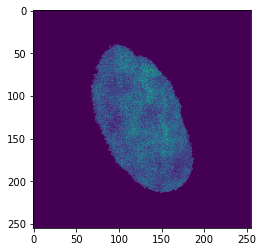

In [19]:
# ds.imgs contains the test and val image splits as MPPData objects
# we can plot images from the test_img / val_img split
import matplotlib.pyplot as plt

plt.imshow(ds.imgs["test"].get_object_img(ds.imgs["test"].obj_ids[0], channel_ids=0, img_size=255)[:, :, 0])

In [20]:
# dataset can returrn a tf dataset for using with e.g. keras
tf_ds = ds.get_tf_dataset(split="train", is_conditional=True)
print(tf_ds)

for x, y in tf_ds.take(1):
    print(x)
    print(y)

<FlatMapDataset shapes: (((3, 3, 34), (14,)), (34,)), types: ((tf.float32, tf.float32), tf.float32)>
(<tf.Tensor: shape=(3, 3, 34), dtype=float32, numpy=
array([[[0.7856049 , 0.06896971, 0.47988248, 0.621853  , 0.7208044 ,
         0.7953104 , 0.73281616, 0.29427582, 0.9713649 , 0.33183968,
         0.45231476, 0.24451347, 0.7914956 , 0.00803955, 0.43829355,
         0.56096125, 0.5416753 , 0.13224284, 0.6091386 , 0.5126373 ,
         0.44654536, 0.72452575, 0.42507517, 0.01375879, 0.43835154,
         1.0814375 , 0.6667864 , 0.06479862, 1.0220959 , 0.6182322 ,
         0.5203733 , 0.03889789, 0.95885843, 0.14463733],
        [0.8928025 , 0.14058743, 0.643348  , 0.23566028, 0.34008306,
         0.84079695, 0.7386245 , 0.3114886 , 0.9777283 , 0.2296075 ,
         0.39278376, 0.2052674 , 0.4252042 , 0.02835273, 0.34685296,
         0.5526775 , 0.54918885, 0.04546713, 0.5222805 , 0.7075824 ,
         0.35585323, 0.63034654, 0.20277092, 0.02187601, 0.51161003,
         1.0574853 , 0.625134

2022-03-18 12:49:46.983594: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 12:49:47.101094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
